In [182]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm
import importlib

import simulate
importlib.reload(simulate)
from simulate import *

In [183]:
# Constants
D = 1.0  # Diffusion coefficient
a = 0.1  # growth rate 
coff = 0.1 #  strength of u^2 non-linearity 
wind = 0.0 #  strength of u'^2 non-linearity 
vf = 2 * (D*a)**0.5
V = 0.9
v = V * vf # wind speed
print(f"v = {v}")

# Lattice
L_N = np.sqrt(D)/a
print("Natural length scale L_N =", L_N)
L = 300.0  # Length of the domain
dx = 0.2# Spatial step size

N = int(L / dx) + 1
print(f"N = {N}")
print(f"L/L_N = {L/L_N}")
print(f"L_N/dx = {L_N/dx}")

filename="u_sols/"+get_filename(D,V,a,wind,coff,N,dx, bc='mixed')
print("Loading", filename)
u = np.load(filename)[-1]

v = 0.5692099788303083
Natural length scale L_N = 10.0
N = 1501
L/L_N = 30.0
L_N/dx = 50.0
Loading u_sols/solution_D_1_v_0.9_a_0.1_wind_0_coff_0.1_N_1501_dx_0.2.npy


In [184]:
from scipy.sparse import diags
from scipy.sparse.linalg import eigs

# First derivative term (v * ∂x)
#v_diagonals = [
#    np.ones(N-1) * (1 / (2 * dx)),  # upper diagonal
#    np.ones(N-1) * (-1 / (2 * dx))  # lower diagonal
#]
#v_term = diags(v_diagonals, [1, -1])
v_term = diags([[-v**2/(4*D) for i in range(N)]], [0])

# Second derivative term (D * ∂x^2)
D_diagonals = [
    np.ones(N) * (-2*D / dx**2),    # main diagonal
    np.ones(N-1) * (D / dx**2),   # upper diagonal
    np.ones(N-1) * (D / dx**2)    # lower diagonal
]
D_term = diags(D_diagonals, [0, 1, -1])

# A_term (a * identity for i > N//4)
A_diag = [a if i > N//4 else 0 for i in range(N)]
A_term = diags([A_diag], [0])

# E_term (E = -coff * u * identity)
E_diag = [-coff * u[i] for i in range(N)]
E_term = diags([E_diag], [0])

# Δ_term (second derivative with custom u)
Δ_diagonals_main = np.array([u[i+1] - 2 * u[i] - u[i-1] for i in range(1, N-1)])
Δ_diagonals_upper = np.array([0.5 * (u[i+1] - u[i-1]) for i in range(1, N-1)])
Δ_diagonals_lower = np.array([-0.5 * (u[i+1] - u[i-1]) for i in range(1, N-1)])

Δ_term_main = np.zeros(N)
Δ_term_main[1:N-1] = Δ_diagonals_main
Δ_term_upper = np.zeros(N-1)
Δ_term_upper[1:] = Δ_diagonals_upper
Δ_term_lower = np.zeros(N-1)
Δ_term_lower[:-1] = Δ_diagonals_lower

Δ_term = diags([Δ_term_main, Δ_term_upper, Δ_term_lower], [0, 1, -1])
Δ_term *= wind / dx**2

# Combine all terms to form L_0

L_mat = (D_term + v_term + A_term + E_term + Δ_term)

L_mat

<1501x1501 sparse matrix of type '<class 'numpy.float64'>'
	with 4501 stored elements (3 diagonals) in DIAgonal format>

In [195]:
# check if hermitian
hermitian = (L_mat!= L_mat.T.conj()).nnz == 0
if not hermitian:  print("L not Hermitian")
else: print("L is Hermitian")
# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = eigs(L_mat.toarray(), k=1501)

# Sort the eigenvalues and eigenvectors
sorted_indices = np.argsort(eigenvalues)
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Print the sorted eigenvalues
print("Number of eigenvalues:", len(eigenvalues_sorted))
print("Sorted Eigenvalues:", eigenvalues_sorted)

L is Hermitian


/tmp/ipykernel_1973628/2798837808.py:6: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  eigenvalues, eigenvectors = eigs(L_mat.toarray(), k=1501)


Number of eigenvalues: 1501
Sorted Eigenvalues: [-1.00079397e+02+0.j -1.00074594e+02+0.j -1.00066605e+02+0.j ...
 -3.11354037e-02+0.j -1.92670523e-02+0.j  4.33553446e-03+0.j]


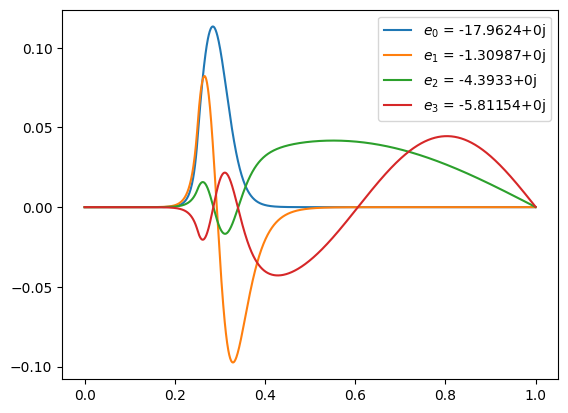

In [209]:
plt.plot(x/L, -np.real(eigenvectors[:, -1]), label=rf"$e_0$ = {eigenvalues[-1]:3g}")#, label="Real part")
plt.plot(x/L, -np.real(eigenvectors[:, -2]), label=rf"$e_1$ = {eigenvalues[-2]:3g}")#, label="Real part")
plt.plot(x/L, -np.real(eigenvectors[:, -3]), label=rf"$e_2$ = {eigenvalues[-3]:3g}")#, label="Real part")
plt.plot(x/L, -np.real(eigenvectors[:, -4]), label=rf"$e_3$ = {eigenvalues[-4]:3g}")#, label="Real part")
plt.legend()

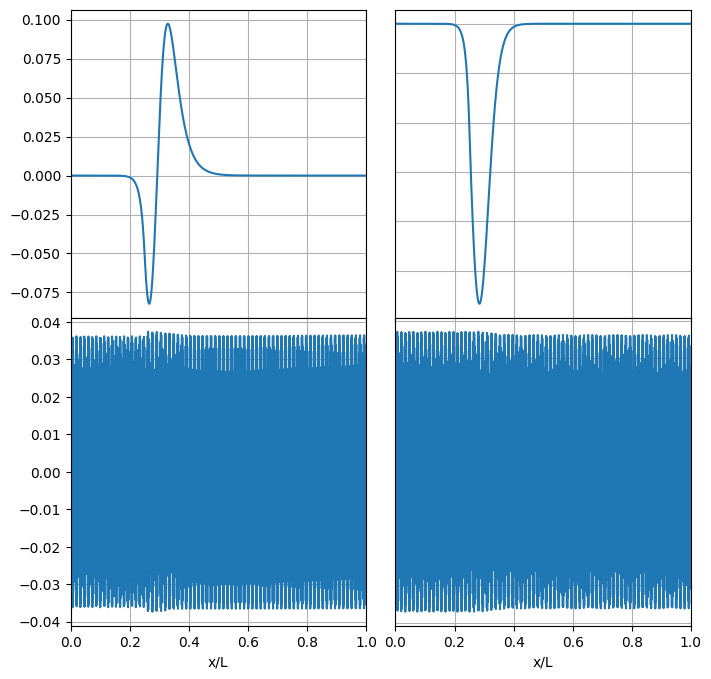

In [191]:
x = np.arange(0,L+dx,dx)
# Create a 2x2 subplot layout
nrows = 2
fig, axs = plt.subplots(2, nrows, figsize=(8, 8), sharex=True)

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Loop through eigenvectors i=0 to i=3
for i in range(len(axs)):
    axs[i].plot(x/L, np.real(eigenvectors[:, i]))#, label="Real part")
    #axs[i].set_ylabel(f"Eigenvector {i}")
    axs[i].set_xlim((0, 1))
    #axs[i].legend()
    axs[i].grid()
    
    if i % 2 == 1:  # Remove y ticks for the second column
        axs[i].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    
    if i < nrows-1:  # Remove x ticks for the first row
        axs[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Set common x-label
axs[2].set_xlabel("x/L")
axs[3].set_xlabel("x/L")

# Remove whitespace between subplots
plt.subplots_adjust(hspace=0.0, wspace=0.1)

# Display the plots
plt.show()

In [163]:
from scipy.sparse.linalg import svds
# Compute the singular value decomposition of L_0
print(L_mat.shape)
u, s, vt = svds(L_mat, k=N-2)

# The null space corresponds to the vectors in vt (transposed)
svd_vectors = vt.T

# Check the singular values to see if there's a null space
print("Singular values:", s[:5])
print("Eigenvalues:    ", s[:5]**2)
print("Number of singular values:", len(s))

(1500, 1500)
Singular values: [0.01926705 0.03113564 0.03170563 0.0327924  0.03437702]
Eigenvalues:     [0.00037122 0.00096943 0.00100525 0.00107534 0.00118178]
Number of singular values: 1499


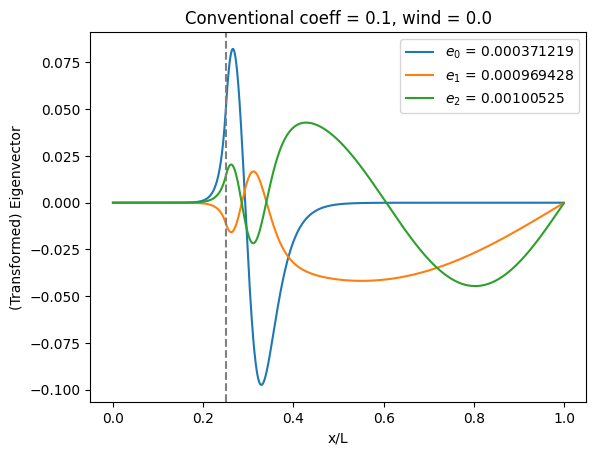

In [164]:
plt.plot(x/L,np.array(svd_vectors[:,0]), label=rf"$e_0$ = {s[0]**2:3g}")
plt.plot(x/L,np.array(svd_vectors[:,1]), label=rf"$e_1$ = {s[1]**2:3g}")
plt.plot(x/L,np.array(svd_vectors[:,2]), label=rf"$e_2$ = {s[2]**2:3g}")

plt.xlabel(r"x/L")
plt.ylabel("(Transformed) Eigenvector")
plt.title(f"Conventional coeff = {coff}, wind = {wind}")
plt.legend()
plt.axvline(0.25, linestyle='--', color='gray')